In [1]:
import numpy as np
import random
from gensim.models import Word2Vec
import gensim.downloader
from scipy.stats import spearmanr
from gensim.models import KeyedVectors
import copy

POP_SIZE = 50
GEN_MAX = 30
MUT_RATE = 0.2
CROSS_RATE = 0.6
VECTOR_SIZE = 50

In [2]:
_glove_model = gensim.downloader.load('glove-wiki-gigaword-50')
_glove_model_changed = gensim.downloader.load('glove-wiki-gigaword-50')

In [3]:
#weat 6
female_attributes = ['female', 'woman', 'girl', 'sister', 'she', 'her', 'hers', 'daughter']
male_attributes = ['male', 'man', 'boy', 'brother', 'he', 'him', 'his', 'son']

careers = ['math', 'algebra', 'geometry', 'calculus', 'equations', 'computation', 'numbers', 'addition', 'poetry', 'art', 'dance', 'literature', 'novel', 'symphony', 'drama', 'sculpture']

def load_dataset(filepath):
    word_pairs = []
    human_scores = []
    with open(filepath, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) == 3:
                word1, word2, score = parts
                score = float(score)
                word_pairs.append((word1.split('-')[0], word2.split('-')[0]))
                human_scores.append(score)
    return word_pairs, human_scores

filepath = 'MEN_dataset_lemma_form.dev'
word_pairs, human_scores = load_dataset(filepath)

men_words = []
for word1, word2 in word_pairs:
    men_words.append(word1)
    men_words.append(word2)

all_words = list(set(female_attributes + male_attributes + careers + men_words))

word_vectors = {word: _glove_model[word] for word in all_words if word in _glove_model}
vectors = np.array([word_vectors[word] for word in word_vectors.keys()])
words = list(word_vectors.keys())
reduced_glove = Word2Vec(vector_size=50, min_count=1)
reduced_glove.build_vocab([words])
reduced_glove.wv.vectors = vectors
reduced_glove.wv.index_to_key = words
reduced_glove.wv.key_to_index = {word: idx for idx, word in enumerate(words)}


In [10]:
def noise_vec(_size=VECTOR_SIZE):
    return np.random.uniform(-2, 2, size=_size)

def crossover(parent1, parent2):
    point1, point2 = sorted(random.sample(range(len(parent1)), 2))
    child1 = np.concatenate((parent1[:point1], parent2[point1:point2], parent1[point2:]))
    child2 = np.concatenate((parent2[:point1], parent1[point1:point2], parent2[point2:]))
    return child1, child2

def mutate(child):
    if random.random() < MUT_RATE:
        child += noise_vec()
    return child

def init_population():
    population = np.ones((POP_SIZE - 1, VECTOR_SIZE)) + np.array([noise_vec() for _ in range(POP_SIZE - 1)])
    population = np.vstack([population, np.ones(VECTOR_SIZE)])
    np.random.shuffle(population)
    return population

def cosine_similarity(v1, v2):
    dot_product = np.dot(v1, v2)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    if norm_v1 == 0 or norm_v2 == 0:
        return 0.0
    return dot_product / (norm_v1 * norm_v2)

def wordembedding_similarity(word_pairs, model):
    embedding_similarities = []
    for word1, word2 in word_pairs:
        if word1 in model and word2 in model:
            v1 = model[word1]
            v2 = model[word2]
            similarity = cosine_similarity(v1, v2)
        else:
            similarity = 0.0
        embedding_similarities.append(similarity)
    return embedding_similarities

def calculate_costs(s, word_pairs, human_scores):
    glove_model_modified = copy.copy(reduced_glove.wv)
    
    for _word in all_words:
        glove_model_modified[_word] = np.multiply(glove_model_modified[_word], s)
        
    differences = [
        abs(
            sum(glove_model_modified.similarity(career, attr) for attr in female_attributes) / len(female_attributes) - 
            sum(glove_model_modified.similarity(career, attr) for attr in male_attributes) / len(male_attributes)
        )
        for career in careers
    ]
    
    bias = sum(differences)

    embedding_similarities = wordembedding_similarity(word_pairs, glove_model_modified)
    spearman_corr, _ = spearmanr(human_scores, embedding_similarities)
    cost_spearman = 1 - spearman_corr
    return [bias,cost_spearman]

In [11]:
def non_dominated_sorting(population, costs):
    sorted_by_dominance = sorted(range(len(population)), key=lambda i: costs[i])
    return [population[i] for i in sorted_by_dominance]

def selection(population, costs):
    return non_dominated_sorting(population, costs)

def nsga2_algorithm():
    population = init_population()
    
    for generation in range(GEN_MAX):
        costs = [calculate_costs(ind, word_pairs, human_scores) for ind in population]
        selected = selection(population, costs)
        
        new_population = []
        while len(new_population) < POP_SIZE:
            parent1, parent2 = random.sample(selected, 2)
            child1, child2 = crossover(parent1, parent2)
            new_population.append(mutate(child1))
            new_population.append(mutate(child2))
        
        population = new_population[:POP_SIZE]
    
    return population

In [12]:
final_population = nsga2_algorithm()

In [13]:
final_population

[array([-1.53933406,  2.6440494 , -3.32697878, -0.09732149, -2.17835763,
        -3.32642524, -0.62955155, -1.23294901, -1.6881289 ,  5.21797515,
        -0.11693465,  0.50457687,  5.54413975,  3.33084853, -5.34681532,
         1.75265913,  0.27323974, -1.16948175,  1.11877178,  2.22305874,
         1.61773449,  6.74940856, -4.77149268, -5.78397199,  4.47089689,
         3.44431459,  4.63284591, -2.41332206, -0.52643734, -9.19235922,
         0.9593415 ,  0.04525238,  1.32223761,  3.849032  ,  2.03401105,
         1.25217927,  2.74949413,  2.98422575,  7.62633123,  3.02971447,
        -1.93679115, -3.65571326,  0.54304937,  1.97787111,  0.35642439,
         3.43513865, -1.98518508, -4.6766001 ,  1.96935843,  2.13576944]),
 array([-0.39048214, -1.25341066, -0.35877908, -0.80561929, -0.78234569,
         1.94383257, -1.72037941,  1.19229392, -1.39538879, -0.96996238,
        -0.62769341,  0.37712938, -1.61933708,  3.75272198,  0.47942065,
        -2.60309874,  0.06491288,  5.56321843,  1

In [14]:
print(calculate_costs(np.ones(50), word_pairs, human_scores))
print(calculate_costs(final_population[0], word_pairs, human_scores))
print(calculate_costs(final_population[1], word_pairs, human_scores))
print(calculate_costs(final_population[20], word_pairs, human_scores))
print(calculate_costs(final_population[30], word_pairs, human_scores))

[0.6343846831296105, 0.3560219442760536]
[1.2692512208013795, 0.41992814408062884]
[1.7985567436626297, 0.43931511536252044]
[0.8317578904825496, 0.37356060536423363]
[0.7528781430737581, 0.5171231834092511]


In [15]:
costs = []
for sol in final_population:
    costs.append(calculate_costs(sol,word_pairs, human_scores))

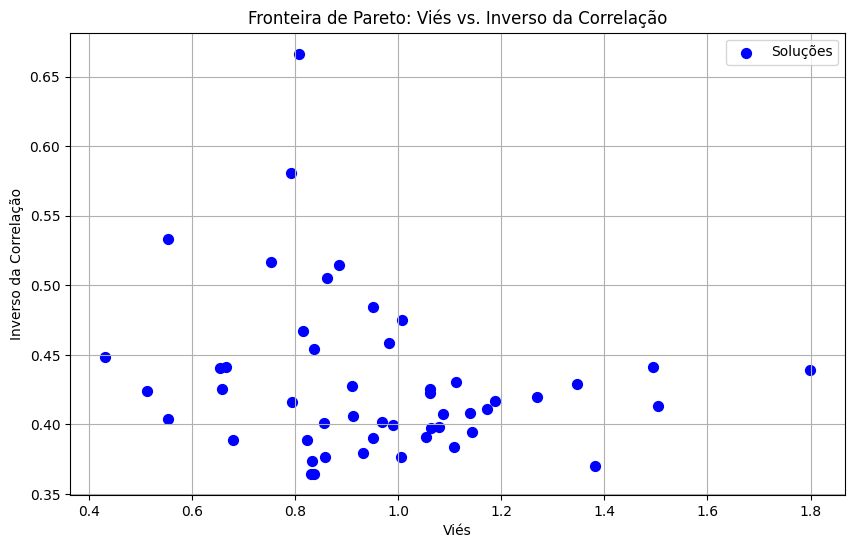

In [17]:
import numpy as np
import matplotlib.pyplot as plt

bias = [cost[0] for cost in costs]
inverse_correlation = [cost[1] for cost in costs]

plt.figure(figsize=(10, 6))
plt.scatter(bias, inverse_correlation, color='blue', s=50, label='Soluções')

plt.title('Fronteira de Pareto: Viés vs. Inverso da Correlação')
plt.xlabel('Viés')
plt.ylabel('Inverso da Correlação')
plt.grid(True)
plt.legend()
plt.show()
